* This notebook implements the SSL model by Kingma (2014).
* C.f. [this implementation](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_tensorflow.py).

> What I cannot create I cannot understand.

## Conditional Variational Auto-encoder

### Motivation

* Conditional variational auto-encoder extends variational auto-encoder.

### Definitions

* Let $X$ be the observed random variable and $Y, Z$ the latent. Let

  \begin{equation}
    Y, Z \sim P_{Y, Z}
  \end{equation}

  be some given prior.
  
* And let

  \begin{equation}
    X \mid Y, Z \sim P_{X \mid Y, Z; \phi}
  \end{equation}

  for some distribution in a family parameterized by $\phi$.
  
For instance, if $X \in \mathbb{R}$, it is general to assume a multivariate Gaussian distribution, diagonalized or semi-diagonalized, then we have

\begin{equation}
  X \mid Y, Z \sim \mathcal{N} \left( \mu(Y; \phi_1), \sigma(Y; \phi_2) \right),
\end{equation}

for some universality functions $\mu(\cdot; \phi_2)$ and $\sigma(\cdot; \phi_2)$ and $\phi := (\phi_1, \phi_2)$.

### Variational Inference

We have the bound by KL-divergence

\begin{align}
  \text{KL} \left( q(z \mid x,y) \| p(z \mid x,y) \right)
  & = \mathbb{E}_{z \sim q(z \mid x,y)} \left[ \ln q(z \mid x,y) - \ln p(x,y,z) \right]
    + \ln p (x, y) \\
  & \geq 0.
\end{align}

Thus, a loss

\begin{align}
  L(x, y)
  & := \mathbb{E}_{z \sim q(z \mid x,y)} \left[
         \ln q(z \mid x,y) - \ln p(x \mid y,z) - \ln p(y,z) \right] \\
  & \geq - \ln p(x, y).
\end{align}

The equality can be reached if and only if $q(z \mid x, y) = p(z \mid x, y)$.

### Relation with Auto-encoder

Regarding this bound as a loss, the $\mathbb{E}_{z \sim q(z \mid x,y)} \left[ - \ln p(x \mid y,z) \right]$ part can be interpreted as a re-construction loss; the $\mathbb{E}_{z \sim q(z \mid x,y)} \left[ - \ln p(y) - \ln p(z) \right]$ part serves as regularization terms.

It seems that the $\mathbb{E}_{z \sim q(z \mid x,y)} \left[ \ln q(z \mid x,y) \right]$ part has no correspondence in auto-encoder.

### Example

In this very example:

\begin{align}
  Y & \sim \text{Categorical uniform}; \\
  Z & \sim \mathcal{N} (0, 1); \\
  X \mid Y, Z & \sim \text{Bernoulli}\left( p(y, z; \theta) \right).
\end{align}

And inference distributions:

\begin{align}
  Z_0 \mid X, Y & \sim \mathcal{N}\left( \mu(x, y; \phi_1), \sigma(x, y; \phi_2) \right); \\
  Z \mid Z_0 & \sim T(z_0).
\end{align}

where $Z_0$ obeys the "base inference distribution", as a Gaussian; and $T$ is bijective with universality.

## Semi-supervised Learning

### Motivation

* Semi-supervised learning utilizes the conditional variational auto-encoder.

### Definitions

* Let

  \begin{equation}
    Y \mid Z \sim P_{Y \mid Z; \theta}.
  \end{equation}
  
  for some distribution in a family parameterized by $\theta$.

### Variational Inference

By the conditional probability formula,

\begin{equation}
  p(y, z \mid x) = p(z \mid x, y) p(y \mid x).
\end{equation}

With this formula, we have the bound by KL-divergence,

\begin{align}
  \text{KL} \left( q(y, z \mid x) \| p(y, z \mid x) \right)
  & = \int q(y, z \mid x) \left[
        \ln q(y, z \mid x) - \ln p(y, z \mid x)
        \right] dy dz \\
  & = \int q(z \mid x, y) q(y \mid x) \left[
        \ln q(z \mid x, y) + \ln q(y \mid x) - \ln p(x \mid y, z) - \ln p(y, z)
        \right] dy dz \\
  & + \ln p(x).
\end{align}

Integrating out $z$ gives

\begin{align}
  \text{KL} \left( q(y, z \mid x) \| p(y, z \mid x) \right)
  & = \int q(y \mid x) \left[ L(x, y) + \ln q(y \mid x) \right] dy  + \ln p(x) \\
  & = \mathbb{E}_{y \sim q(y \mid x)} \left[ L(x, y) \right]
    - \mathcal{H} \left[ q(y \mid x) \right]
    + \ln p(x) \\
  & \geq 0.
\end{align}

Thus a loss

\begin{align}
  U(x) & := \mathbb{E}_{y \sim q(y \mid x)} \left[ L(x, y) \right]
          - \mathcal{H} \left[ q(y \mid x) \right] \\
       & \geq - \ln p(x).
\end{align}

The equality can be reached if and only if $q(y \mid x) = p(y \mid x)$, then $q(y, z \mid x) = p(y, z \mid x)$.

The trick in the training is that, the minimization of $L(x, y)$ has **completed** the training of the variables in $p(x \mid y, z)$ and $q(z \mid x, y)$, which, thus, shall
**not** be trained further in the minimization of $U(x)$.

(The strange thing is that, after training the variables in $p(x \mid y, z)$ and $q(z \mid x, y)$ by minimizing $L(x, y)$, if train them further in the minimizing of $U(x)$, then the trained variables will give a **higher** $L(x, y)$ than that after the minimization of its own. Why?)

### Example

In this very example:

\begin{equation}
  Y \mid Z \sim \text{Categorical} \left( \pi(Z; \theta) \right).
\end{equation}

## Implementation

In this implementation, we follow the spirit of TensorFlow, hiding the parameters of functions. That is, define `L(X, y; phi)` as `L(phi)(X, y)`.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from tensorflow.contrib.distributions.python.ops import bijectors as tfb
from tensorflow.examples.tutorials.mnist import input_data

# For reproducibility
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

### Functions

In [2]:
def get_q_z_Xy(X, y, z_dim, bijectors=None, dtype='float32',
               name='q_z_Xy', reuse=None):
  """Returns the distribution of Z | X, Y.
  
  Z = bijector(Z_0), and
  Z_0 | X, Y ~ Normal(mu(X,Y;phi), sigma(X,Y;phi)).
  
  Args:
    X: Tensor with shape `[batch_size, X_dim]`.
    y: Tensor with shape `[batch_size, y_dim]`.
  
  Returns:
    An instance of `tfd.Distribution`.
  """
  if bijectors is None:
    bijectors = []
    
  with tf.variable_scope(name, reuse=reuse):
    # For concatenating, the dtype shall be the same
    X = tf.cast(X, dtype)
    y = tf.cast(y, dtype)
    
    input_ = tf.concat([X, y], axis=1)
    hidden = tf.layers.dense(input_, 512, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 256, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 128, activation=tf.nn.relu)
    # Outputs in the fiber-bundle space
    output = tf.layers.dense(hidden, z_dim * 2, activation=None)
    # shape: [batch_size, z_dim]
    mu, log_var = tf.split(output, [z_dim, z_dim], axis=1)
    
    q_z0_Xy = tfd.MultivariateNormalDiag(mu, tf.exp(log_var))
    chain = tfb.Chain(bijectors)
    q_z_Xy = tfd.TransformedDistribution(distribution=q_z0_Xy,
                                         bijector=chain)
    return q_z_Xy

In [3]:
def get_bijectors(name='bjiectors', reuse=None):
  """Complexify the inference distribution by extra-bijectors like
  normalizing flows.
  
  Returns:
    List of `Bijector`s.
  """
  with tf.variable_scope(name, reuse=reuse):
    bijectors = []
    for i in range(10):
      shift_and_log_scale_fn = \
        tfb.masked_autoregressive_default_template([128])
      # MAP is extremely slow in training. Use IAF instead.
      bijector = tfb.Invert(
          tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn))
      bijectors.append(bijector)
    return bijectors

In [4]:
def get_p_X_yz(y, z, X_dim, dtype='float32', name='p_X_yz', reuse=None):
  """Returns the distribution of X | Y, Z.
  
  X | Y, Z ~ Bernoulli( p(Y, Z; theta) ).
    
  Args:
    y: Tensor with shape `[batch_size, y_dim]` and dtype `float32`.
    z: Tensor with shape `[batch_size, z_dim]` and dtype `float32`.
    X_dim: Positive integer.
    
  Returns:
    An instance of `tfd.Distribution`.
  """
  with tf.variable_scope(name, reuse=reuse):
    # For concatenating, the dtype shall be the same
    y = tf.cast(y, dtype)
    z = tf.cast(z, dtype)
    
    input_ = tf.concat([y, z], axis=1)
    hidden = tf.layers.dense(input_, 128, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 256, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 512, activation=tf.nn.relu)
    logits = tf.layers.dense(hidden, X_dim, activation=None)  
    
    p_X_yz = tfd.Independent(tfd.Bernoulli(logits=logits))
    return p_X_yz

In [5]:
def get_loss_Xy(get_q_z_Xy, get_p_X_yz, p_y=None, p_z=None, reuse=None):
  """L(X,y) := E_{z ~ q(z|X,y)} [ log_q(z|X,y) - log_p(y) - log_p(z)
                                  - log_p(X|y,z) ].
                                  
  (Herein we assume the prior p(y, z) = p(y) p(z). Even though this is
   principly non-essential, I do not how to implement such independence
   in TensorFlow.)
  
  Args:
    get_q_z_Xy: Callable that returns an instance of `tfd.Distribution`,
      as the q(z|X,y), which takes arguments `X`, `y`, and `reuse`.
    get_p_X_yz: Callable that returns an instance of `tfd.Distribution`,
      as the p(X|y,z), which takes arguments `y`, `z`, and `reuse`.
    p_y: An instance of `tfd.Distribution`, as the p(y). Defaults to
      flatten prior.
    p_z: An instance of `tfd.Distribution`, as the p(z). Defaults to
      flatten prior.
    reuse: If reuse the variables in `get_q_z_Xy` and `get_p_X_yz`.
    
  Returns:
    Callable that maps two tensors of the shape `[batch_size, x_dim]`
    and `[batch_size, y_dim]`, respectively, to a scalar.
  """
  
  def loss_Xy(X, y, name='loss_Xy'):
    """
    Args:
      X: Tensor of the shape `[batch_size, X_dim]`.
      y: Tensor of the shape `[batch_size, y_dim]`.

    Returns:
      A scalar.
    """
    with tf.name_scope(name):
      # Get the distribution q(z|X,y)
      q_z_Xy = get_q_z_Xy(X, y, reuse=reuse)
      
      # Get the distribution p(X|y,z)
      z_samples = q_z_Xy.sample()
      p_X_yz = get_p_X_yz(y, z_samples, reuse=reuse)
      
      # Compute the tensor of L(X,y)
      loss_Xy_tensor = tf.zeros([batch_size])  # initialize.
      # E_{z ~ q(z|X,y)} [ log_q(z|X,y) ]
      loss_Xy_tensor += q_z_Xy.log_prob(z_samples)
      if p_y is not None:
        # E_{z ~ q(z|X,y)} [ - log_p(y) ]
        loss_Xy_tensor += -1 * p_y.log_prob(y)
      if p_z is not None:
        # E_{z ~ q(z|X,y)} [ - log_p(z) ]
        loss_Xy_tensor += -1 * p_z.log_prob(z_samples)
      # E_{z ~ q(z|X,y)} [ - log_p(X|y,z) ]
      loss_Xy_tensor += -1 * p_X_yz.log_prob(X)
      loss_Xy_scalar = tf.reduce_mean(loss_Xy_tensor)
      return loss_Xy_scalar
    
  return loss_Xy

In [6]:
def get_q_y_X(X, name='q_y_X', reuse=None):
  """Returns the distribution of Y | X.
  
  Y | X ~ Categorical( pi(X; alpha) ).
  
  Args:
    X: Tensor of the shape `[batch_size, X_dim]`.
    
  Returns:
    An instance of `tfd.Distribution`.
  """
  with tf.variable_scope(name, reuse=reuse):
    hidden = tf.layers.dense(X, 512, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 256, activation=tf.nn.relu)
    hidden = tf.layers.dense(hidden, 128, activation=tf.nn.relu)
    # Outputs in the fiber-bundle space
    logits = tf.layers.dense(hidden, y_dim, activation=None)
    q_y_X = tfd.Independent(tfd.OneHotCategorical(logits=logits))
    return q_y_X

In [7]:
def get_loss_X(q_y_X, loss_Xy, name='loss_X'):
  """U(X) := E_{y ~ q(y|X)} [ L(X,y) ] - H(q(y|X)).
  
  Args:
    q_y_X: An instance of `tfd.Distribution` as the q(y|X).
    loss_Xy: Callabe as the L(X, y) with X given.
    
  Returns:
    Callable that maps a tensor of the shape `[batch_size, X_dim]`
    to a scalar.
  """
  def loss_X(X):
    """
    Args:
      X: Tensor of the shape `[batch_size, X_dim]`.
      
    Returns:
      A scalar.
    """
    with tf.name_scope(name):
      y_samples = q_y_X.sample()
      loss_X_scalar = loss_Xy(X, y_samples) \
                    - tf.reduce_mean(q_y_X.entropy())
      return loss_X_scalar
  return loss_X

In [8]:
import collections

def get_dependent_variables(tensor_or_tensors):
  """Returns all variables that the tensor `tensor` depends on.
  
  Folked from: https://stackoverflow.com/a/42861919/1218716
  
  Args:
    tensor_or_tensors: Tensor or a collection of tensors.
    
  Returns:
    List of variables.
  """
  if isinstance(tensor_or_tensors, (list, tuple, set)):  # a collection.
    tensors = tensor_or_tensors
    dependent_vars = []
    for tensor in tensors:
      dependent_vars += get_dependent_variables(tensor)
    return list(set(dependent_vars))
  # When not a collection,
  tensor = tensor_or_tensors
  
  # Initialize
  starting_op = tensor.op
  dependent_vars = []
  queue = collections.deque()
  queue.append(starting_op)
  op_to_var = {var.op: var for var in tf.trainable_variables()}
  visited = set([starting_op])

  while queue:
    op = queue.popleft()
    try:
      dependent_vars.append(op_to_var[op])
    except KeyError:
      # `op` is not a variable, so search its inputs (if any). 
      for op_input in op.inputs:
        if op_input.op not in visited:
          queue.append(op_input.op)
          visited.add(op_input.op)
          
  return dependent_vars

In [9]:
def gradient_clipping(loss, var_list=None, threshold=1.0, clip_method=None):
  """Gradient clipping for avoiding the explosion of gradents in training.
  Returns a list of gradient-variable pairs which can be directly supplied
  as the argument `grads_and_vars` of `tf.Optimizer.apply_gradient()`.
  
  Args:
    loss: Scalar.
    var_list: List of `tf.Variable`s. Defaults to all the variables the
      `loss` depends on.
    threshold: Positive real number.
    clip_method: Callable with signature like `tf.clip_by_value`. Defaults
      to `tf.clip_by_value`.
      
    Returns:
      List of tuples of two elements. The fisrt is `d loss / d var`, and
      the second the `var`.
    """
  if var_list is None:
    var_list = get_dependent_variables(loss)
  if clip_method is None:
    clip_method = tf.clip_by_value
  thr = threshold  # for short.

  grads = tf.gradients(loss, var_list)
  capped_grads = [clip_method(g, -thr, thr) for g in grads]
  grads_and_vars = [(g, v) for g, v in zip(capped_grads, var_list)]
  return grads_and_vars

### Loss

In [10]:
batch_size = 128
X_dim = 28 * 28
y_dim = 10

X = tf.placeholder(shape=[batch_size, X_dim], dtype='float32', name='X')
y = tf.placeholder(shape=[batch_size, y_dim], dtype='float32', name='y')

In [11]:
z_dim = 64

p_z = tfd.MultivariateNormalDiag(tf.zeros([z_dim]), name='p_z')

In [12]:
def _get_q_z_Xy(X, y, reuse):
  bijectors = get_bijectors(reuse=reuse)
  #bijectors = []  # for comparison
  return get_q_z_Xy(X, y, z_dim, bijectors, reuse=reuse)

def _get_p_X_yz(y, z, reuse):
  return get_p_X_yz(y, z, X_dim=X_dim, reuse=reuse)

loss_Xy = get_loss_Xy(_get_q_z_Xy, _get_p_X_yz,
                      p_z=p_z, reuse=tf.AUTO_REUSE)
loss_Xy_scalar = loss_Xy(X, y)

In [13]:
q_y_X = get_q_y_X(X, reuse=tf.AUTO_REUSE)
y_samples = q_y_X.sample()

In [14]:
loss_X = get_loss_X(q_y_X, loss_Xy)
loss_X_scalar = loss_X(X)

### Training

In [16]:
# Minimize L(X,y)
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
minimize_loss_Xy = optimizer.minimize(loss_Xy_scalar)

In [17]:
# Minimize U(X), while fixing the variables in L(X,y)
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
loss_X_vars = [_ for _ in get_dependent_variables(loss_X_scalar)
               if _ not in get_dependent_variables(loss_Xy_scalar)]
minimize_loss_X = optimizer.minimize(loss_X_scalar, var_list=loss_X_vars)

### Generating

In [18]:
# X | Y,Z
z_samples_ph = tf.placeholder(shape=[batch_size, z_dim], dtype='float32')
p_X_yz_gen = _get_p_X_yz(y, z_samples_ph, reuse=tf.AUTO_REUSE)
X_samples = p_X_yz_gen.sample()

In [19]:
def get_image(array):
  """
  Args:
    array: Numpy array with shape `[28*28]`.
    
  Returns:
    An image.
  """
  return PIL.Image.fromarray((255 * array.reshape([28, 28]))\
                             .astype(np.uint8))

### Having Fun

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
mnist = input_data.read_data_sets('dat/MNIST', one_hot=True)

def get_X_y_batch():
    X_batch, y_batch = mnist.train.next_batch(batch_size)
    # Since X | Y, Z ~ Bernoulli, the observed value of X shall
    # either be 0 or 1,
    X_batch = np.where(X_batch >= 0.5, np.ones_like(X_batch),
                       np.zeros_like(X_batch))
    return X_batch, y_batch

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting dat/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting dat/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting dat/MNIST/t10k-images-idx3-ubyte.gz
Extracting dat/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


100%|██████████| 100000/100000 [13:59<00:00, 119.14it/s]


Mean L(X,y): 71.1763
Final L(X,y): 65.8304


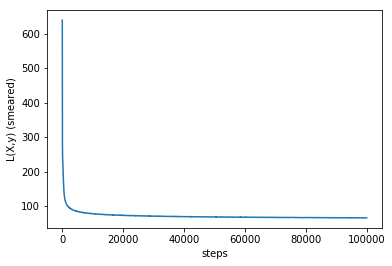

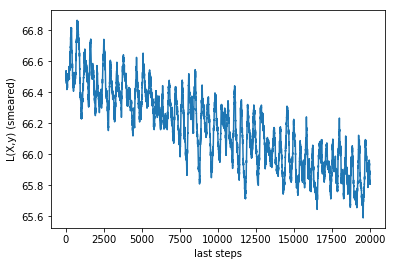

In [22]:
# Training by minimizing `loss_Xy_scalar`
loss_Xy_vals = []
smeared_loss_Xy_vals = []
smear_steps = 300
for i in tqdm(range(100000)):
  X_batch, y_batch = get_X_y_batch()
  _, loss_Xy_val = sess.run([minimize_loss_Xy, loss_Xy_scalar],
                            feed_dict={X: X_batch, y: y_batch})
  if np.isnan(loss_Xy_val):
    raise ValueError('Loss has been NaN.')
  loss_Xy_vals.append(loss_Xy_val)
  smeared_loss_Xy_vals.append(np.mean(loss_Xy_vals[-smear_steps:]))
print('Mean L(X,y):', np.mean(loss_Xy_vals))
print('Final L(X,y):', smeared_loss_Xy_vals[-1])

# Visualize the training loss
plt.plot(smeared_loss_Xy_vals)
plt.xlabel('steps')
plt.ylabel('L(X,y) (smeared)')
plt.show()

# Visualize the training loss in the last several steps
last_steps = 20000
plt.plot(smeared_loss_Xy_vals[-last_steps:])
plt.xlabel('last steps')
plt.ylabel('L(X,y) (smeared)')
plt.show()

In [31]:
X_batch, y_batch = get_X_y_batch()

# Generated
z_samples_val = np.random.normal(size=[batch_size, z_dim])
X_sample_vals = sess.run(X_samples,
    feed_dict={y: y_batch, z_samples_ph: z_samples_val})

# Display the results
print('Label:', np.argmax(y_batch[0]))
print('Gnerated:')
get_image(X_sample_vals[0])

Label: 7
Gnerated:


In [24]:
'''
# Training by minimizing `loss_X_scalar`
loss_X_vals = []
smeared_loss_X_vals = []
for i in tqdm(range(100000)):
  X_batch, y_batch = get_X_y_batch()
  _, loss_X_val = sess.run([minimize_loss_X, loss_X_scalar],
                            feed_dict={X: X_batch})
  if np.isnan(loss_X_val):
    raise ValueError('Loss has been NaN.')
  loss_X_vals.append(loss_X_val)
  smeared_loss_X_vals.append(np.mean(loss_X_vals[-smear_steps:]))
print('Mean U(X):', np.mean(loss_X_vals))
print('Final U(X):', smeared_loss_X_vals[-1])

# Visualize the training loss
plt.plot(smeared_loss_X_vals)
plt.xlabel('steps')
plt.ylabel('U(X) (smeared)')
plt.show()

# Visualize the training loss in the last several steps
plt.plot(smeared_loss_X_vals[-last_steps:])
plt.xlabel('last steps')
plt.ylabel('U(X) (smeared)')
plt.show()
'''

"\n# Training by minimizing `loss_X_scalar`\nloss_X_vals = []\nsmeared_loss_X_vals = []\nfor i in tqdm(range(100000)):\n  X_batch, y_batch = get_X_y_batch()\n  _, loss_X_val = sess.run([minimize_loss_X, loss_X_scalar],\n                            feed_dict={X: X_batch})\n  if np.isnan(loss_X_val):\n    raise ValueError('Loss has been NaN.')\n  loss_X_vals.append(loss_X_val)\n  smeared_loss_X_vals.append(np.mean(loss_X_vals[-smear_steps:]))\nprint('Mean U(X):', np.mean(loss_X_vals))\nprint('Final U(X):', smeared_loss_X_vals[-1])\n\n# Visualize the training loss\nplt.plot(smeared_loss_X_vals)\nplt.xlabel('steps')\nplt.ylabel('U(X) (smeared)')\nplt.show()\n\n# Visualize the training loss in the last several steps\nplt.plot(smeared_loss_X_vals[-last_steps:])\nplt.xlabel('last steps')\nplt.ylabel('U(X) (smeared)')\nplt.show()\n"

In [25]:
'''
X_batch, y_batch = get_X_y_batch()

# Predicted
y_sample_vals = sess.run(y_samples, feed_dict={X: X_batch})

# Display the results
print('Label:', np.argmax(y_batch[0]))
print('Predicted:', np.argmax(y_sample_vals[0]))
print('Original:')
get_image(X_batch[0])
'''

"\nX_batch, y_batch = get_X_y_batch()\n\n# Predicted\ny_sample_vals = sess.run(y_samples, feed_dict={X: X_batch})\n\n# Display the results\nprint('Label:', np.argmax(y_batch[0]))\nprint('Predicted:', np.argmax(y_sample_vals[0]))\nprint('Original:')\nimage = get_image(X_batch[0])\nimage.show()\n"

### Effect of Normalizing-flow

* While not employing normalizing flow, 100000 iterations give the final L(X,y) about 70.0.
* With 10 normalizing flows, 100000 iterations give the L(X,y) loss 65.5 (improved 4.5).